# Data Cleaning Essar Resource Optimization

In [152]:
import pandas as pd
from utils import read_json
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

The data was resampled to 1 hour granularity. Tags were given more interperable names, and tags not used in the optimization process are dropped.

Since the data shifts after the year 2021, the datasets were split into two time periods (2017 - 2020, and 2021 to current). The first time periods is saved, and used for the first stage on the analysis.

In [153]:
# READ IN DATA
tag_desca = read_json('../Data/f201a_tagdesc.json')
df_a = pd.read_csv('../../Config_Data_Pipe/hist_data_download/Output/f201a_hist_data.csv', index_col = 'Date')
df_a.index = pd.to_datetime(df_a.index)
df_a = df_a.resample('1h').mean()

tag_descb = read_json('../Data/f201b_tagdesc.json')
df_b = pd.read_csv('../../Config_Data_Pipe/hist_data_download/Output/f201b_hist_data.csv', index_col = 'Date')
df_b.index = pd.to_datetime(df_b.index)
df_b = df_b.resample('1h').mean()

tag_descc = read_json('../Data/f201c_tagdesc.json')
df_c = pd.read_csv('../../Config_Data_Pipe/hist_data_download/Output/f201c_hist_data.csv', index_col = 'Date')
df_c.index = pd.to_datetime(df_c.index)
df_c = df_c.resample('1h').mean()

tag_descd = read_json('../Data/f202_tagdesc.json')
df_d = pd.read_csv('../../Config_Data_Pipe/hist_data_download/Output/f202_hist_data.csv', index_col = 'Date')
df_d.index = pd.to_datetime(df_d.index)
df_d = df_d.resample('1h').mean()

# REWRITE COL NAMES
df_a.columns = [tag_desca[tag].replace(' ', '_') for tag in [tag.replace(':', '').replace(' Stanlow', '') for tag in df_a.columns.tolist()]]
df_b.columns = [tag_descb[tag].replace(' ', '_') for tag in [tag.replace(':', '').replace(' Stanlow', '') for tag in df_b.columns.tolist()]]
df_c.columns = [tag_descc[tag].replace(' ', '_') for tag in [tag.replace(':', '').replace(' Stanlow', '') for tag in df_c.columns.tolist()]]
df_d.columns = [tag_descd[tag].replace(' ', '_') for tag in [tag.replace(':', '').replace(' Stanlow', '') for tag in df_d.columns.tolist()]]

df_a = df_a.drop(['TAN_CRUDE_EX_E201A/B', 'CRUDE_SALT',
                  'SETPOINT', 'Fuel_Oil_Pressure',
                  'FUEL_GAS_BURNER_PRES'], axis = 1)

df_b = df_b.drop(['TAN_CRUDE_EX_E201A/B', 'CRUDE_SALT',
                  'SETPOINT', 'CD4_F201B_Fuel_Oil_Pressure',
                  'F201B_FUEL_GAS_BURNER_PRES'], axis = 1)

df_c = df_c.drop(['TAN_CRUDE_EX_E201A/B', 'CRUDE_SALT',
                  'SETPOINT', 'CD4_F201C_Fuel_Oil_Pressure',
                  'F201C_FUEL_GAS_BURNER_PRES'], axis = 1)

df_d = df_d.drop(['CD4_F202_Fuel_Oil_Pressure', 'F202_FUEL_GAS_BURNER_PRESS',
                  'SETPOINT'], axis = 1)

# FILTER
def filter_year_df(df):
    return df[df.index.year < 2021], df[df.index.year >= 2021]

pre_df_a, post_df_a  = filter_year_df(df_a)
pre_df_b, post_df_b  = filter_year_df(df_b)
pre_df_c, post_df_c  = filter_year_df(df_c)
pre_df_d, post_df_d  = filter_year_df(df_d)

print("Observations Furnace A:", pre_df_a.shape[0])
print("Observations Furnace B:", pre_df_b.shape[0])
print("Observations Furnace C:", pre_df_c.shape[0])
print("Observations Furnace D:", pre_df_d.shape[0])

Observations Furnace A: 35064
Observations Furnace B: 35064
Observations Furnace C: 35064
Observations Furnace D: 35064


# Pre-Drift Data 2017 - 2020

Observations where over 50% of tag values were missing were omitted from the analysis as these observations are likely not reliable or informative. We can see that this decision does not cost us a lot of data (3.7% of obs at most).

In [154]:
# few sections where majority of vars are missing, drop these
drop_pre_df_a = pre_df_a.dropna(axis = 0, thresh = 6)
drop_pre_df_b = pre_df_b.dropna(axis = 0, thresh = 6)
drop_pre_df_c = pre_df_c.dropna(axis = 0, thresh = 6)
drop_pre_df_d = pre_df_d.dropna(axis = 0, thresh = 6)

print("Observations Retained Furnace A:", round(drop_pre_df_a.shape[0]/pre_df_a.shape[0] * 100, 1))
print("Observations Retained Furnace B:", round(drop_pre_df_b.shape[0]/pre_df_b.shape[0] * 100, 1))
print("Observations Retained Furnace C:", round(drop_pre_df_c.shape[0]/pre_df_c.shape[0] * 100, 1))
print("Observations Retained Furnace D:", round(drop_pre_df_d.shape[0]/pre_df_d.shape[0] * 100, 1))

Observations Retained Furnace A: 96.6
Observations Retained Furnace B: 96.3
Observations Retained Furnace C: 97.7
Observations Retained Furnace D: 99.0


INLET_TEMP and COMBUSTION_AIR_TEMP are missing the largest amount of obserations (19.4% and 8.7%). Instances with less than 3 consecutive NA's were interpolating linearly. 

In [155]:
round(drop_pre_df_a.isna().sum()/drop_pre_df_a.shape[0]* 100, 1)
# round(drop_pre_df_b.isna().sum()/drop_pre_df_b.shape[0]* 100, 1)
# round(drop_pre_df_c.isna().sum()/drop_pre_df_c.shape[0]* 100, 1)
# round(drop_pre_df_d.isna().sum()/drop_pre_df_d.shape[0]* 100, 1)

OIL                     0.2
GAS                     0.5
COMBUSTION_AIR          0.2
INLET1                  0.8
INLET2                  1.7
INLET3                  1.3
INLET4                  1.1
O2_GAS                  4.6
COMBUSTION_AIR_TEMP     8.7
OUTLET                  1.2
INLET_TEMP             19.4
GAS_DENS                0.1
dtype: float64

In [ ]:
drop_pre_df_a.loc[:, "INLET_TEMP"].interpolate(limit = 2, inplace=True)
drop_pre_df_a.loc[:, "COMBUSTION_AIR_TEMP"].interpolate(limit = 2, inplace=True)

drop_pre_df_b.loc[:, "INLET_TEMP"].interpolate(limit = 2, inplace=True)
drop_pre_df_b.loc[:, "COMBUSTION_AIR_TEMP"].interpolate(limit = 2, inplace=True)

drop_pre_df_c.loc[:, "INLET_TEMP"].interpolate(limit = 2, inplace=True)
drop_pre_df_c.loc[:, "COMBUSTION_AIR_TEMP"].interpolate(limit = 2, inplace=True)

drop_pre_df_d.loc[:, "INLET_TEMP"].interpolate(limit = 2, inplace=True)
drop_pre_df_d.loc[:, "COMBUSTION_AIR_TEMP"].interpolate(limit = 2, inplace=True)

After linear interpolating, any observations with missing tags were omittied. We still retain a very high amount of observations. 

In [157]:
print("Retained furnace A: ", round(drop_pre_df_a.dropna().shape[0]/pre_df_a.shape[0] * 100, 1))
print("Retained furnace B: ", round(drop_pre_df_b.dropna().shape[0]/pre_df_b.shape[0] * 100, 1))
print("Retained furnace C: ", round(drop_pre_df_c.dropna().shape[0]/pre_df_c.shape[0] * 100, 1))
print("Retained furnace D: ", round(drop_pre_df_d.dropna().shape[0]/pre_df_d.shape[0] * 100, 1))

Retained furnace A:  87.9
Retained furnace B:  86.5
Retained furnace C:  89.5
Retained furnace D:  86.3


In [158]:
clean_df_a = drop_pre_df_a.dropna()
clean_df_b = drop_pre_df_b.dropna()
clean_df_c = drop_pre_df_c.dropna()
clean_df_d = drop_pre_df_d.dropna()

Inlets were summed due to high correlation. Treating inlet as 1 variable rather than a multitude of tags will make things easier moving forward.

C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\4155876040.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();
C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\4155876040.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


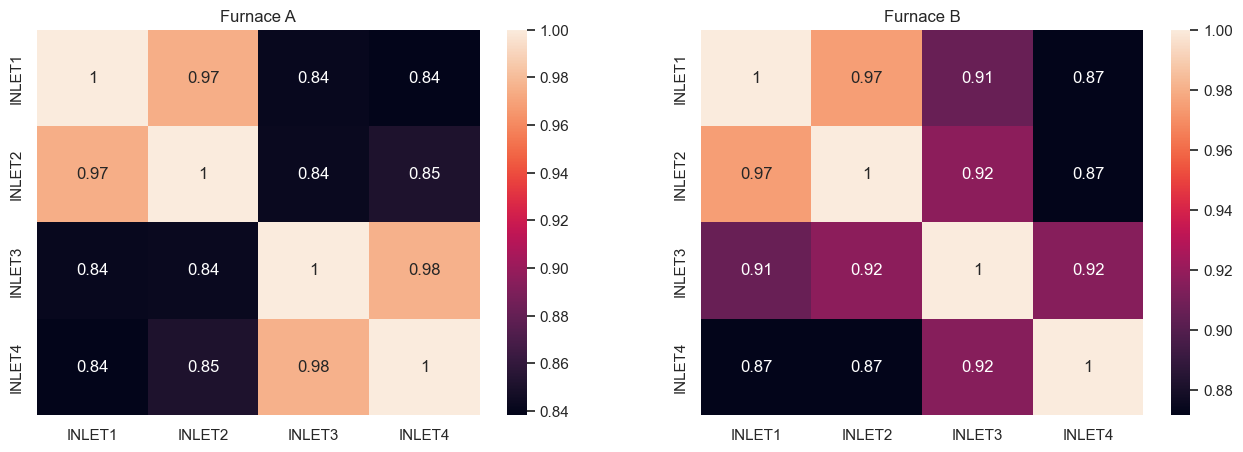

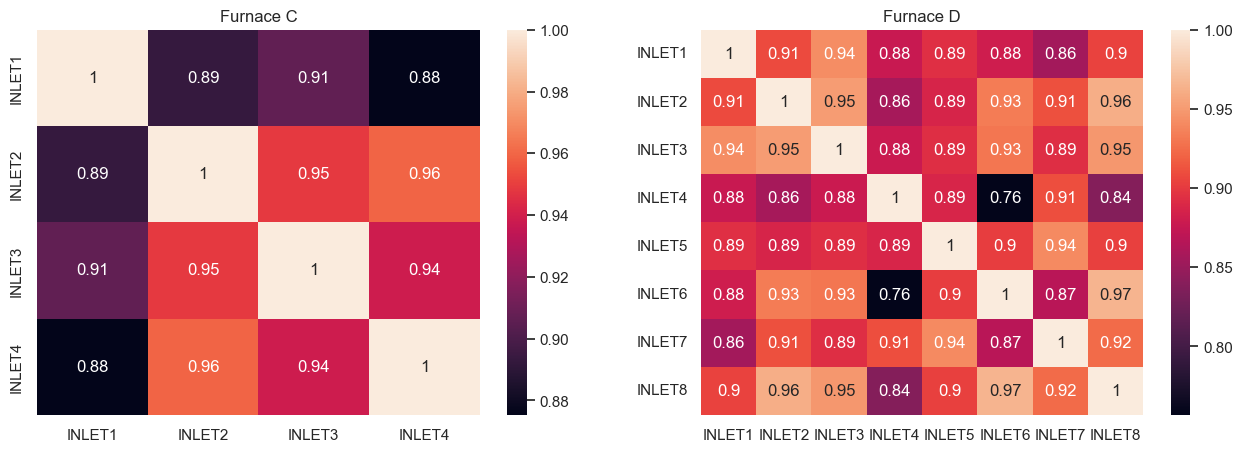

In [159]:
inlet_df_a = clean_df_a.loc[:, ['INLET1', 'INLET2', 'INLET3', 'INLET4']]
inlet_df_b = clean_df_b.loc[:, ['INLET1', 'INLET2', 'INLET3', 'INLET4']]
inlet_df_c = clean_df_c.loc[:, ['INLET1', 'INLET2', 'INLET3', 'INLET4']]
inlet_df_d = clean_df_d.loc[:, ['INLET1', 'INLET2', 'INLET3', 'INLET4',
                               'INLET5', 'INLET6', 'INLET7', 'INLET8']]

corr_a = inlet_df_a.corr()
corr_b = inlet_df_b.corr()
corr_c = inlet_df_c.corr()
corr_d = inlet_df_d.corr()

fig, ax =plt.subplots(1,2);
sns.set(rc={'figure.figsize':(15.7,5)})
sns.heatmap(corr_a, annot = True, ax=ax[0]);
ax[0].set_title('Furnace A');
sns.heatmap(corr_b, annot = True, ax=ax[1]);
ax[1].set_title('Furnace B');
fig.show();


fig, ax =plt.subplots(1,2);
sns.heatmap(corr_c, annot = True, ax=ax[0]);
ax[0].set_title('Furnace C');
sns.heatmap(corr_d, annot = True, ax=ax[1]);
ax[1].set_title('Furnace D');
fig.show();

In [ ]:
# ADD INLETS AS SUM, DROP INDIVIDUAL
clean_df_a['INLET_SUM'] = clean_df_a.loc[:, 'INLET1'] + clean_df_a.loc[:, 'INLET2'] + clean_df_a.loc[:, 'INLET3'] + clean_df_a.loc[:, 'INLET4']
clean_df_b['INLET_SUM'] = clean_df_b.loc[:, 'INLET1'] + clean_df_b.loc[:, 'INLET2'] + clean_df_b.loc[:, 'INLET3'] + clean_df_b.loc[:, 'INLET4']
clean_df_c['INLET_SUM'] = clean_df_c.loc[:, 'INLET1'] + clean_df_c.loc[:, 'INLET2'] + clean_df_c.loc[:, 'INLET3'] + clean_df_c.loc[:, 'INLET4'] 
clean_df_d['INLET_SUM'] = clean_df_d.loc[:, 'INLET1'] + clean_df_d.loc[:, 'INLET2'] + clean_df_d.loc[:, 'INLET3'] + clean_df_d.loc[:, 'INLET4'] + clean_df_d.loc[:, 'INLET5'] + clean_df_d.loc[:, 'INLET6'] + clean_df_d.loc[:, 'INLET7'] + clean_df_d.loc[:, 'INLET8']

clean_df_a.drop(['INLET1', 'INLET2', 'INLET3', 'INLET4'], axis = 1, inplace = True)
clean_df_b.drop(['INLET1', 'INLET2', 'INLET3', 'INLET4'], axis = 1, inplace = True)
clean_df_c.drop(['INLET1', 'INLET2', 'INLET3', 'INLET4', 'INLET5', 'INLET6', 'INLET7', 'INLET8'], axis = 1, inplace = True)
clean_df_d.drop(['INLET1', 'INLET2', 'INLET3', 'INLET4', 'INLET5', 'INLET6', 'INLET7', 'INLET8'], axis = 1, inplace = True)

There was a period of time in 2018 which showed low values for the setpoint. These were omitted from the data. We still return a great amount of our original observations.

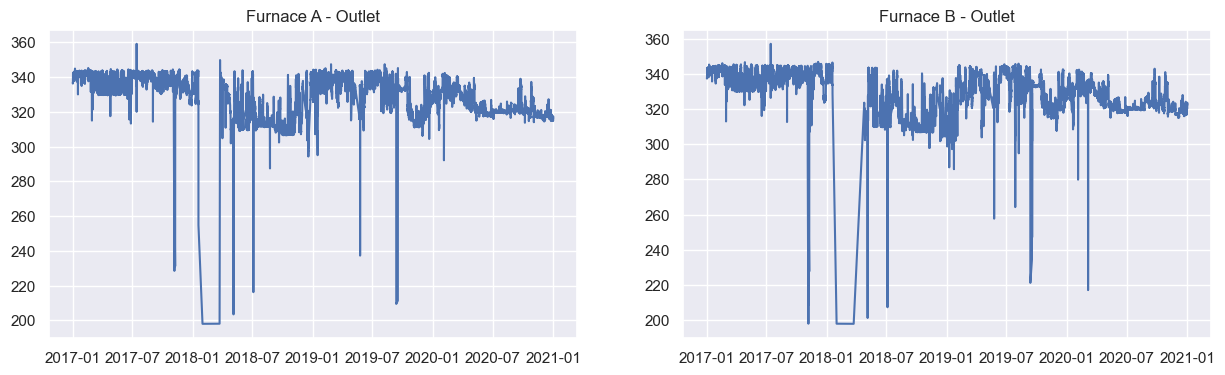

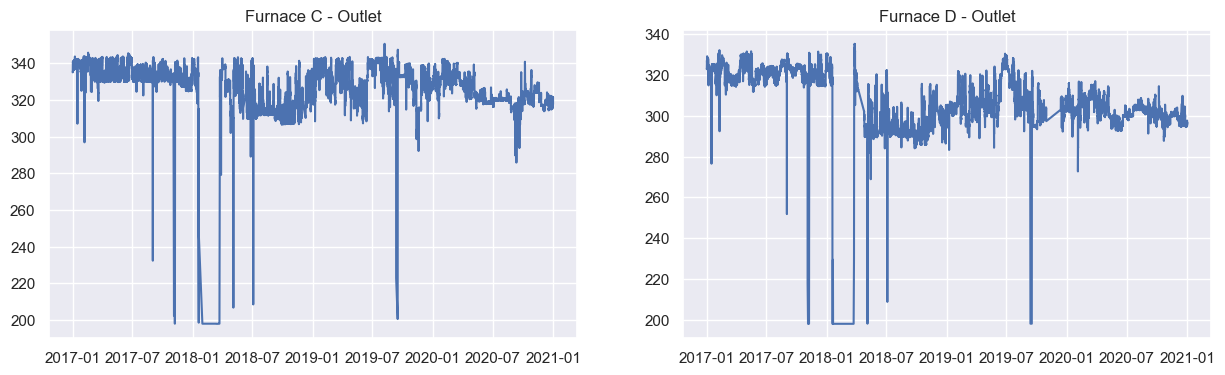

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(clean_df_a['OUTLET'])
axes[0].set_title('Furnace A - Outlet');
axes[1].plot(clean_df_b['OUTLET'])
axes[1].set_title('Furnace B - Outlet');

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(clean_df_c['OUTLET'])
axes[0].set_title('Furnace C - Outlet');
axes[1].plot(clean_df_d['OUTLET'])
axes[1].set_title('Furnace D - Outlet');

In [162]:
clean_df_a = clean_df_a[(clean_df_a.index < '2018-01-15') | (clean_df_a.index > '2018-03-25')]
clean_df_b = clean_df_b[(clean_df_b.index < '2018-01-15') | (clean_df_b.index > '2018-04-25')]
clean_df_c = clean_df_c[(clean_df_c.index < '2018-01-15') | (clean_df_c.index > '2018-04-25')]
clean_df_d = clean_df_d[(clean_df_d.index < '2018-01-15') | (clean_df_d.index > '2018-03-25')]

In [163]:
print("Retained furnace A: ", round(clean_df_a.shape[0]/pre_df_a.shape[0] * 100, 1))
print("Retained furnace B: ", round(clean_df_b.shape[0]/pre_df_b.shape[0] * 100, 1))
print("Retained furnace C: ", round(clean_df_c.shape[0]/pre_df_c.shape[0] * 100, 1))
print("Retained furnace D: ", round(clean_df_d.shape[0]/pre_df_d.shape[0] * 100, 1))

Retained furnace A:  86.9
Retained furnace B:  85.4
Retained furnace C:  86.6
Retained furnace D:  85.2


In [164]:
dfa_y = clean_df_a.loc[:, 'OUTLET']
dfa_x = clean_df_a.loc[:, clean_df_a.columns != 'OUTLET']

dfb_y = clean_df_b.loc[:, 'OUTLET']
dfb_x = clean_df_b.loc[:, clean_df_b.columns != 'OUTLET']

dfc_y = clean_df_c.loc[:, 'OUTLET']
dfc_x = clean_df_c.loc[:, clean_df_c.columns != 'OUTLET']

dfd_y = clean_df_d.loc[:, 'OUTLET']
dfd_x = clean_df_d.loc[:, clean_df_d.columns != 'OUTLET']

# EDA

In [165]:
def plot_all(dfa, dfb, dfc, dfd, variable):
    print(variable)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(dfa.loc[:, variable], color = 'red')
    axes[0].set_title('Furnace A');
    axes[1].plot(dfb.loc[:, variable], color = 'blue')
    axes[1].set_title('Furnace B');
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(dfc[variable], color = 'red')
    axes[0].set_title('Furnace C');
    axes[1].plot(dfd[variable], color = 'blue')
    axes[1].set_title('Furnace D');
    plt.show();
    
    plt.plot(dfa[variable], label = 'A');
    plt.plot(dfb[variable], label = 'B');
    plt.plot(dfc[variable], label = 'C');
    plt.plot(dfd[variable], label = 'D');
    plt.title('All Furnaces')
    plt.legend();

## Outlet (Response)

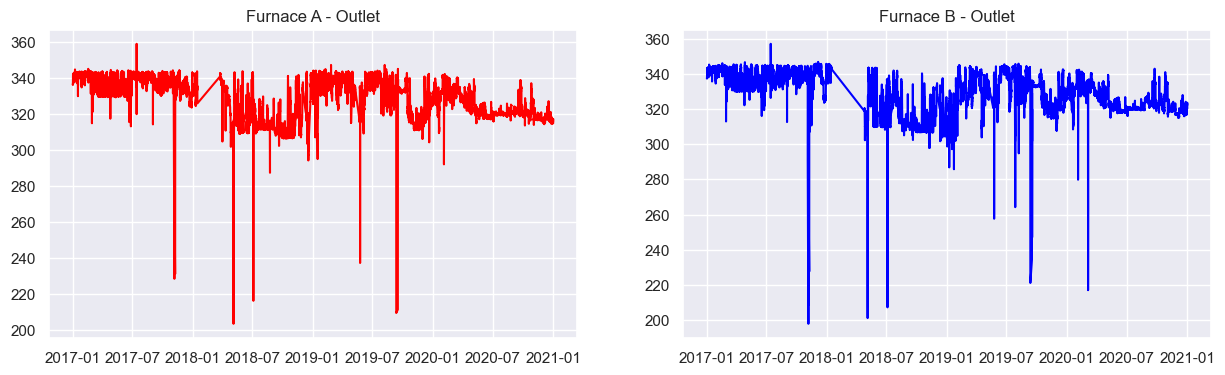

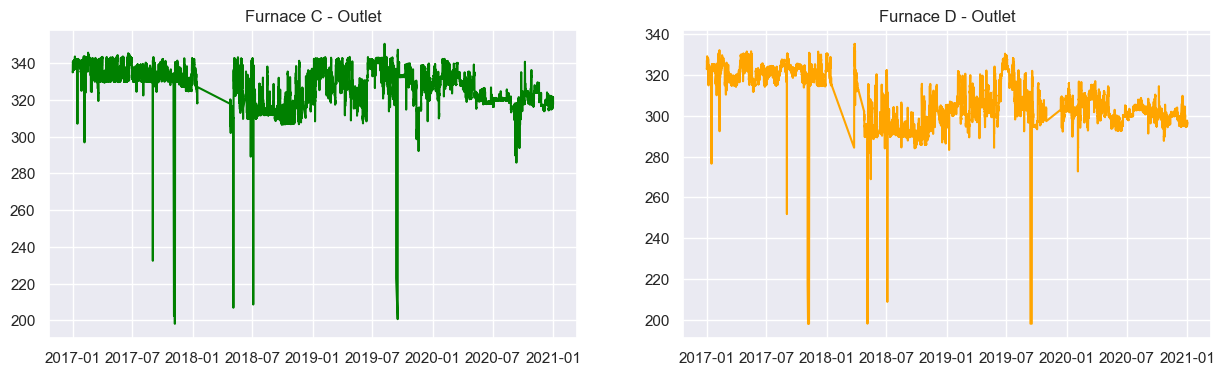

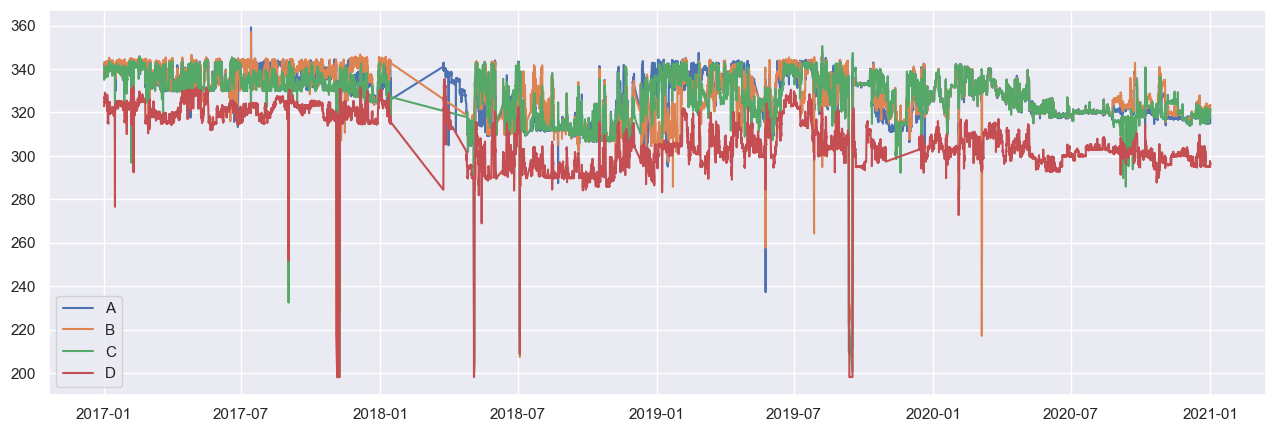

In [166]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(dfa_y, color = 'red')
axes[0].set_title('Furnace A - Outlet');
axes[1].plot(dfb_y, color = 'blue')
axes[1].set_title('Furnace B - Outlet');


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].plot(dfc_y, color = 'green')
axes[0].set_title('Furnace C - Outlet');
axes[1].plot(dfd_y, color = 'orange')
axes[1].set_title('Furnace D - Outlet');
plt.show();

plt.plot(dfa_y, label = 'A');
plt.plot(dfb_y, label = 'B');
plt.plot(dfc_y, label = 'C');
plt.plot(dfd_y, label = 'D');
plt.legend();

## OIL

OIL


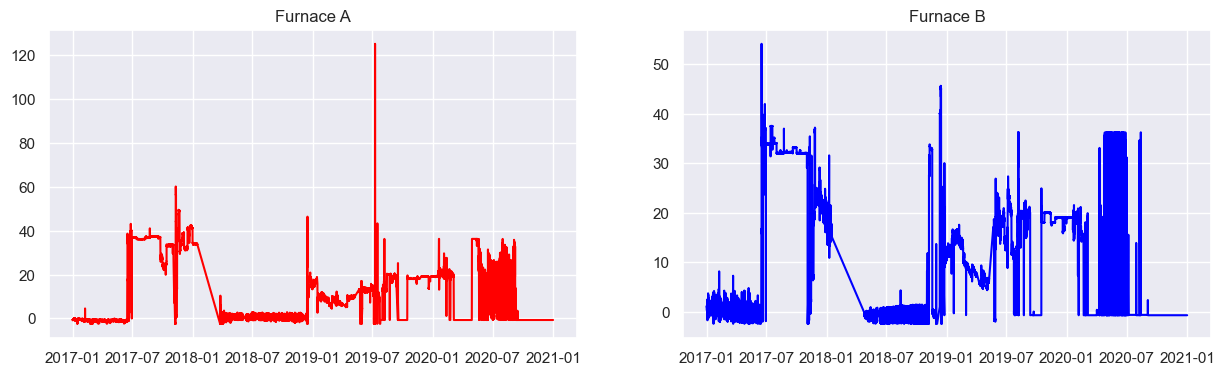

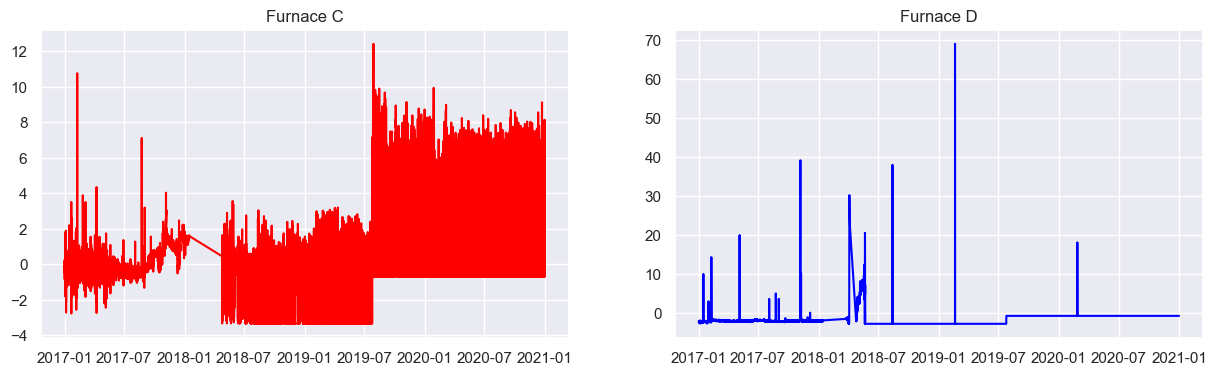

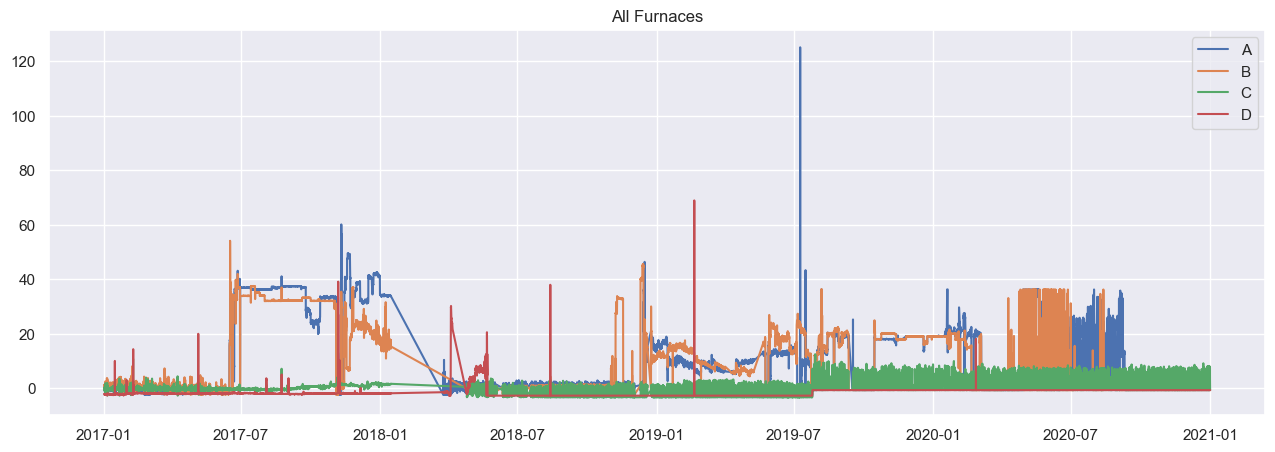

In [167]:
plot_all(dfa_x, dfb_x, dfc_x, dfd_x, 'OIL')

## GAS

GAS


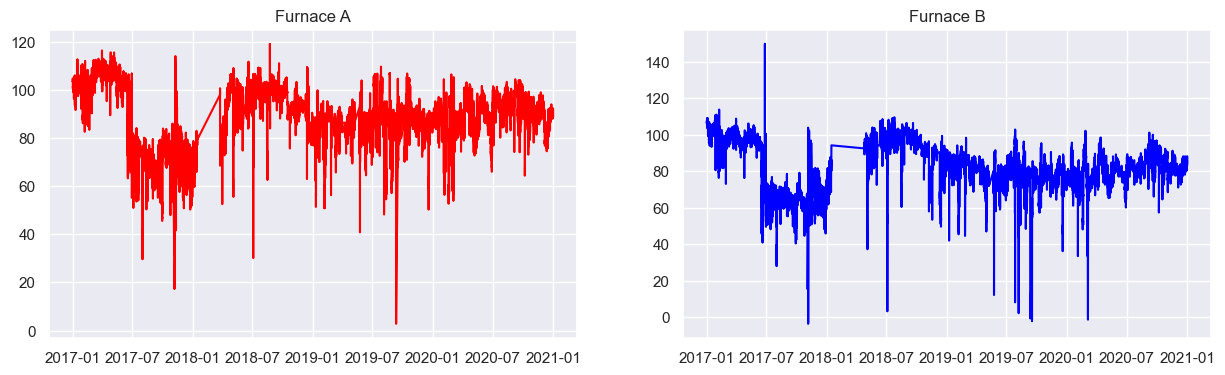

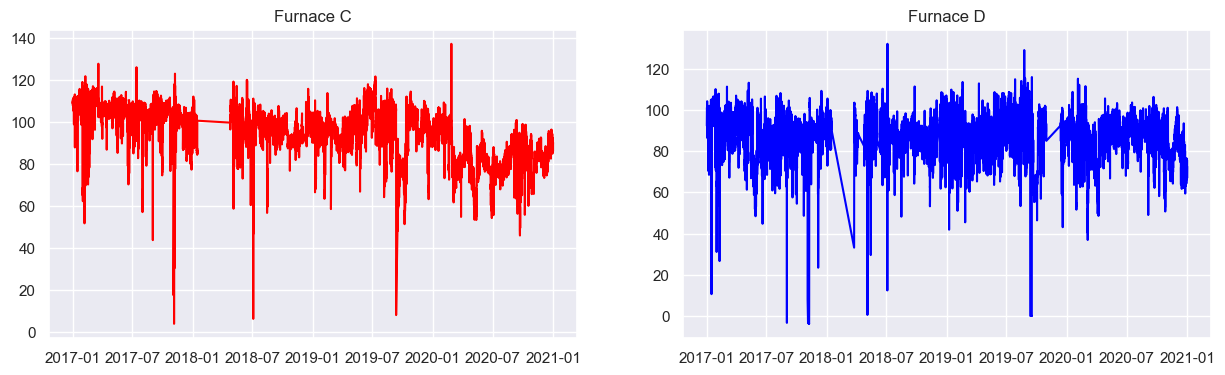

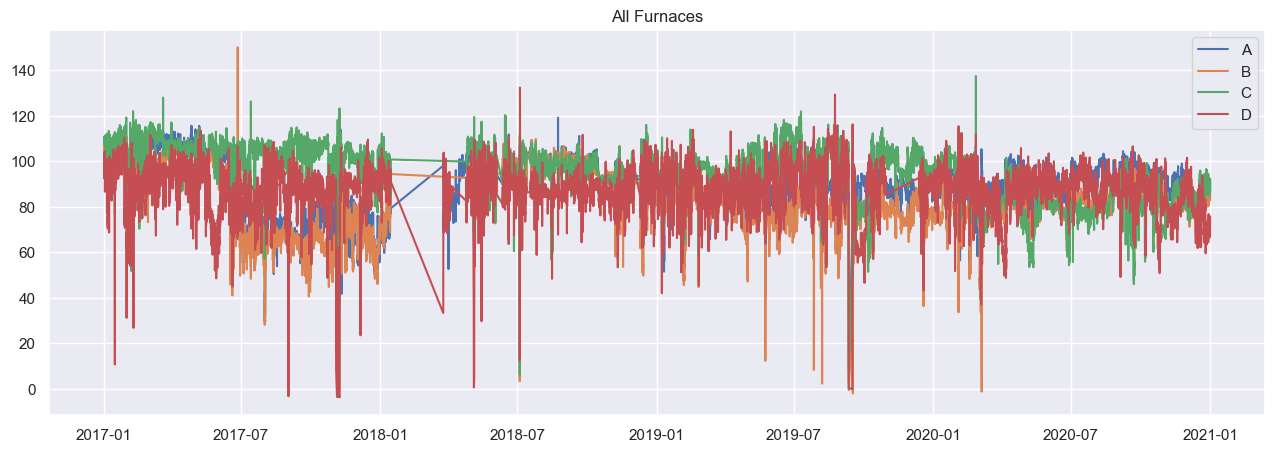

In [168]:
plot_all(dfa_x, dfb_x, dfc_x, dfd_x, 'GAS')

## COMBUSTION AIR

COMBUSTION_AIR


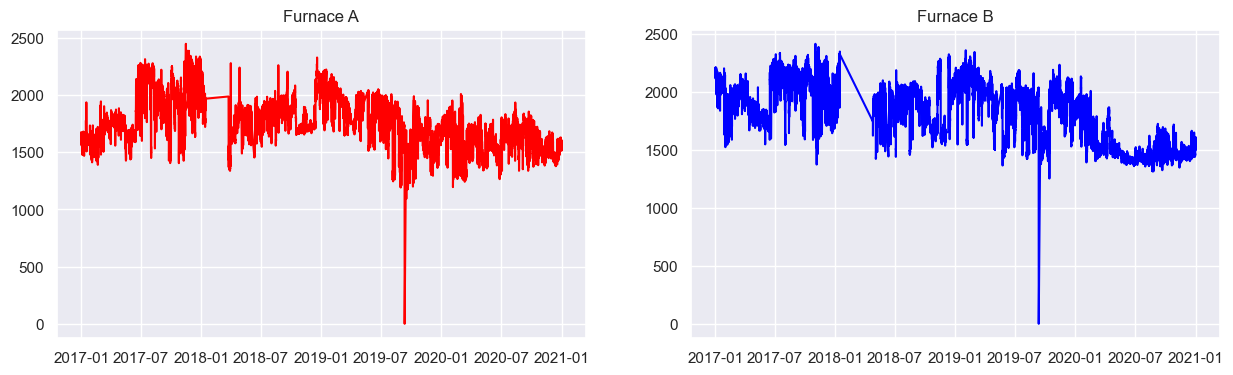

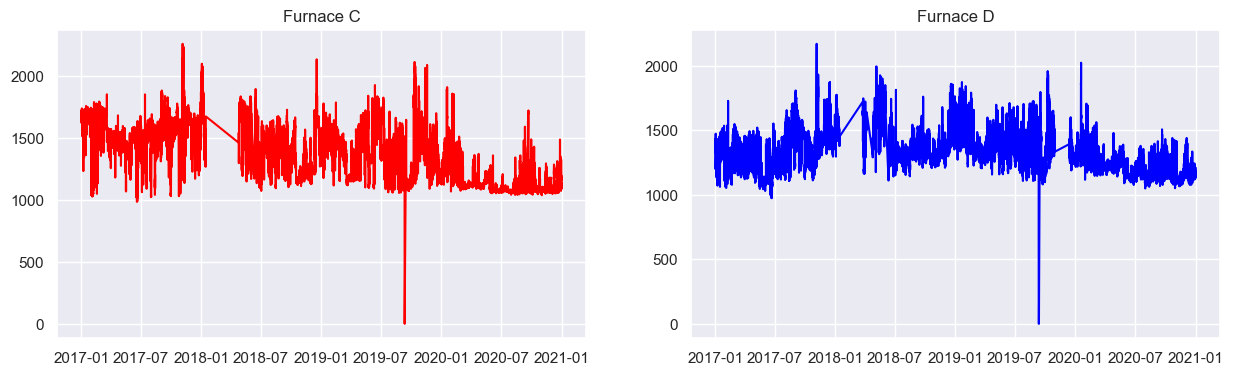

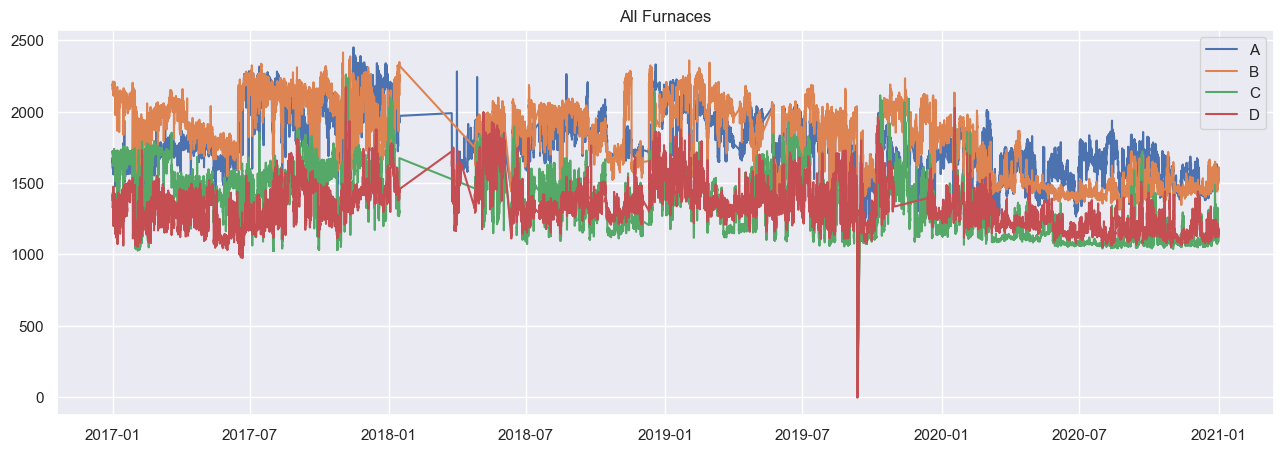

In [169]:
plot_all(dfa_x, dfb_x, dfc_x, dfd_x, 'COMBUSTION_AIR')

## INLET

INLET_SUM


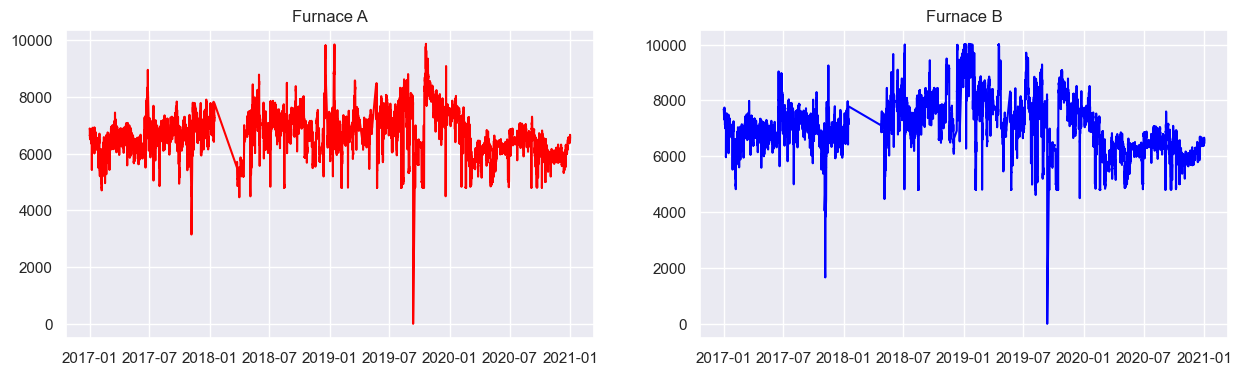

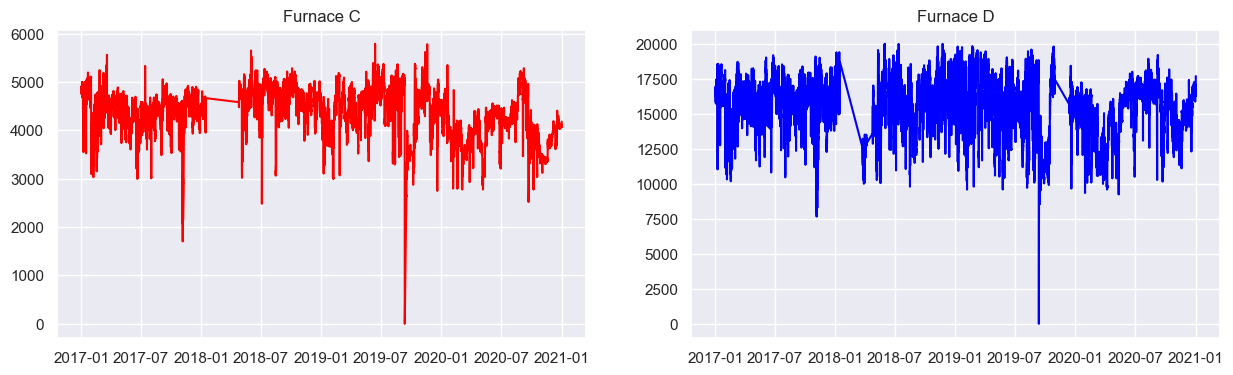

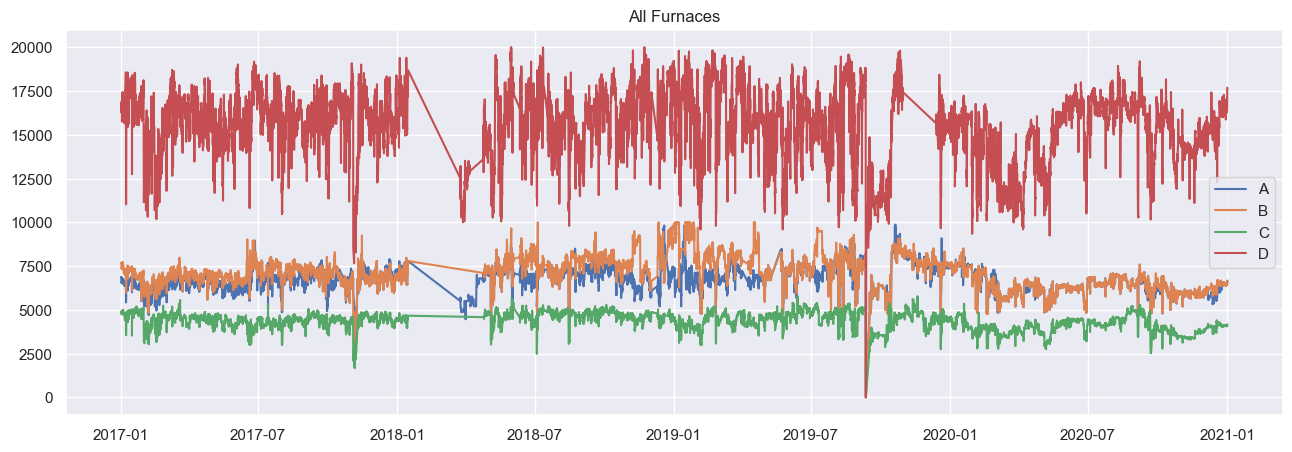

In [170]:
plot_all(dfa_x, dfb_x, dfc_x, dfd_x, 'INLET_SUM')

## COMBUSTION AIR TEMP

COMBUSTION_AIR_TEMP


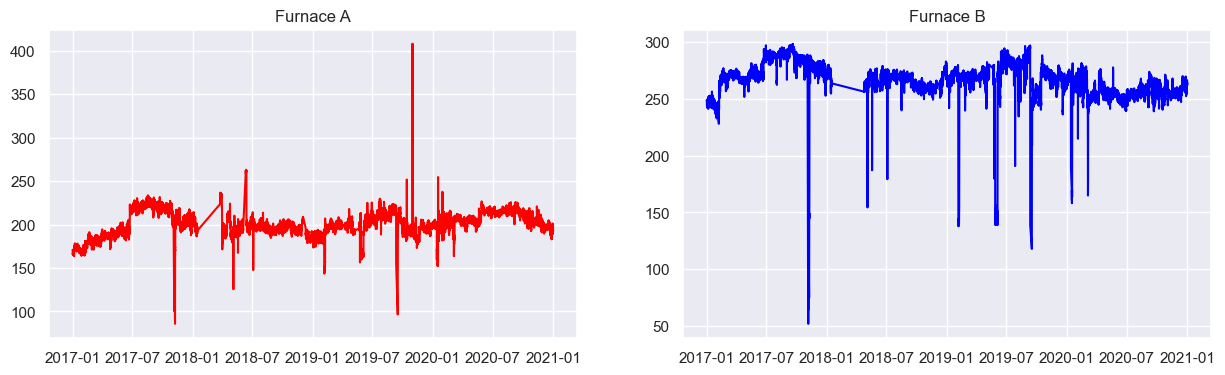

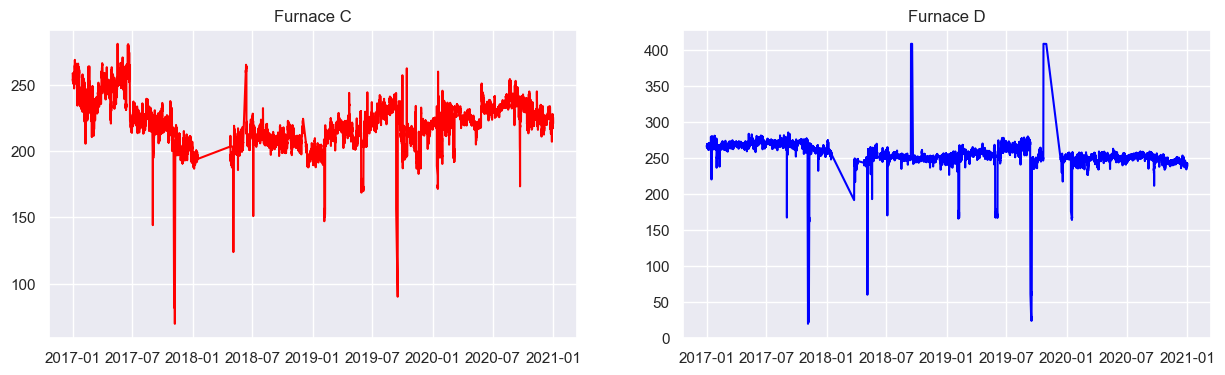

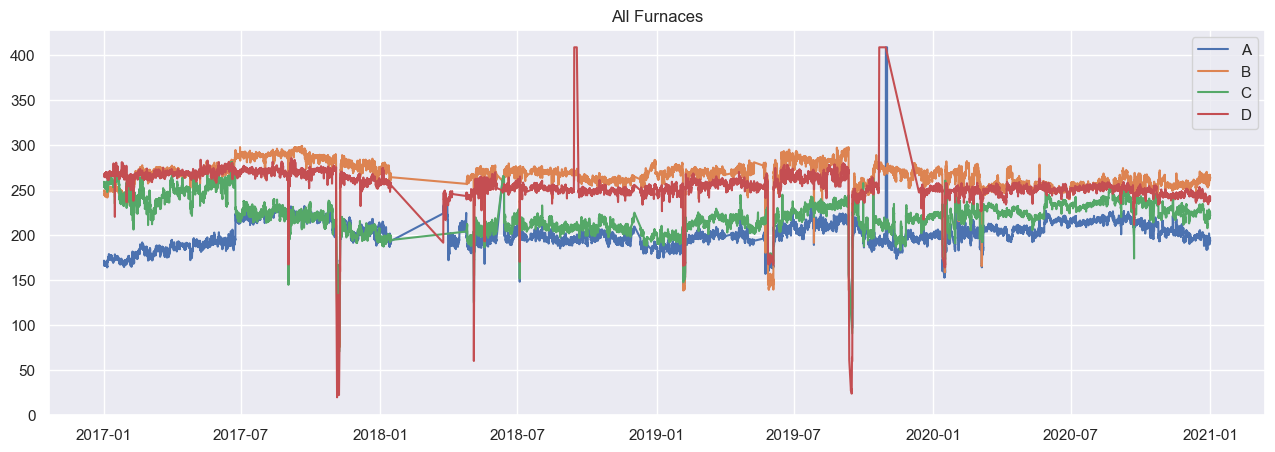

In [171]:
plot_all(dfa_x, dfb_x, dfc_x, dfd_x, 'COMBUSTION_AIR_TEMP')

## INLET_TEMP

INLET_TEMP


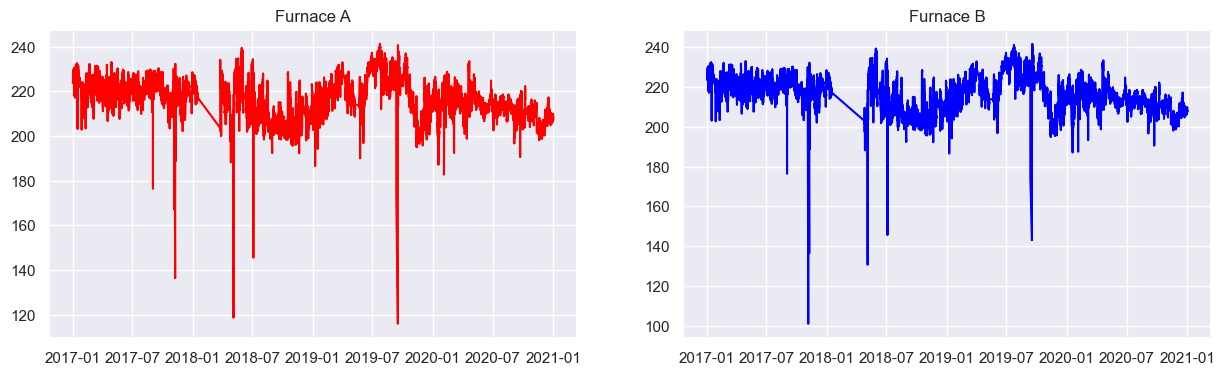

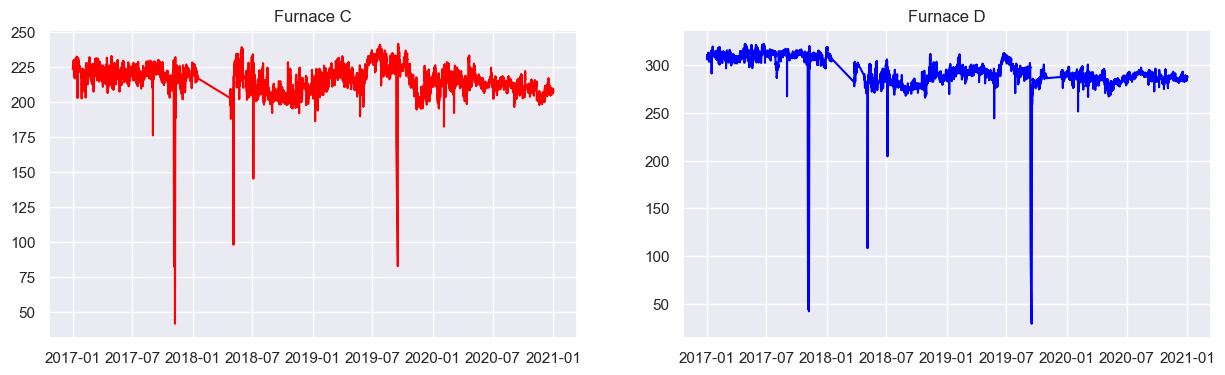

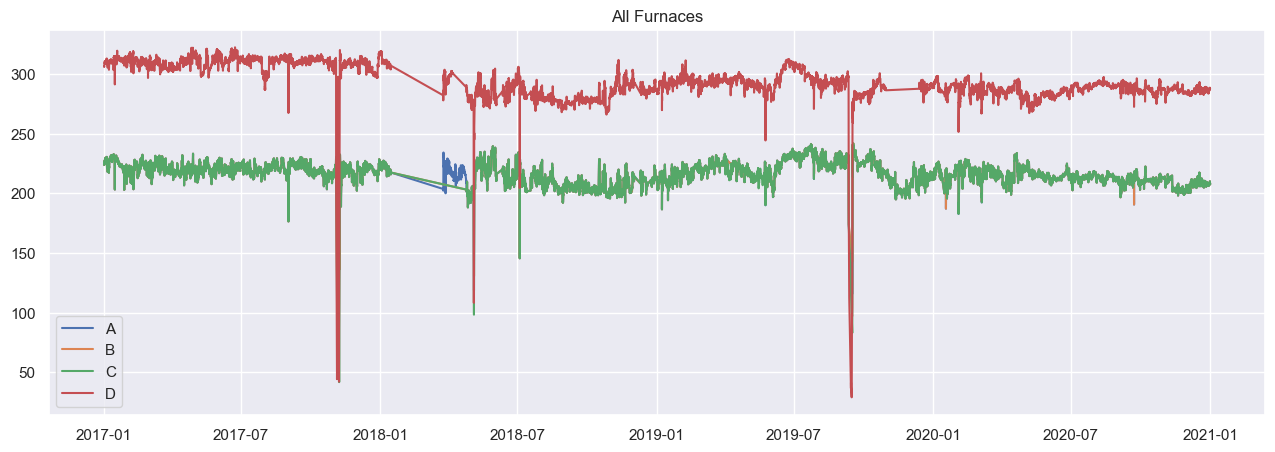

In [172]:
plot_all(dfa_x, dfb_x, dfc_x, dfd_x, 'INLET_TEMP')

## Correlations

C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\3197690159.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();
C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\3197690159.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


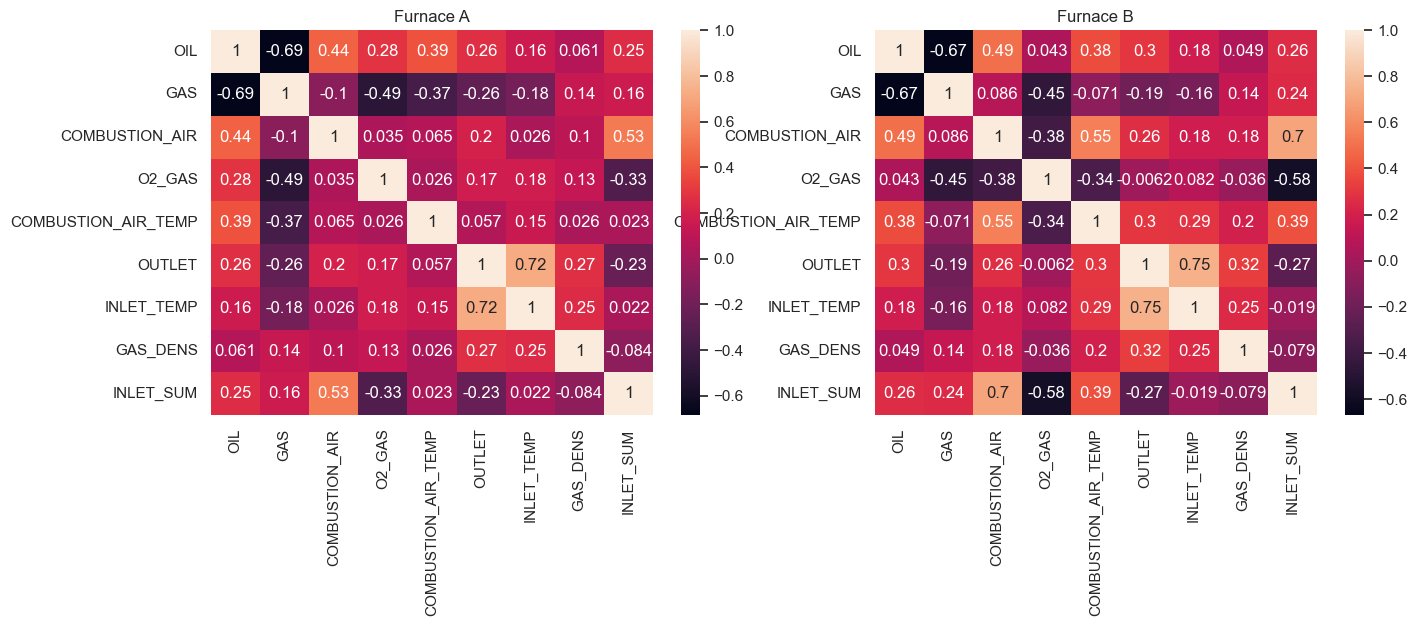

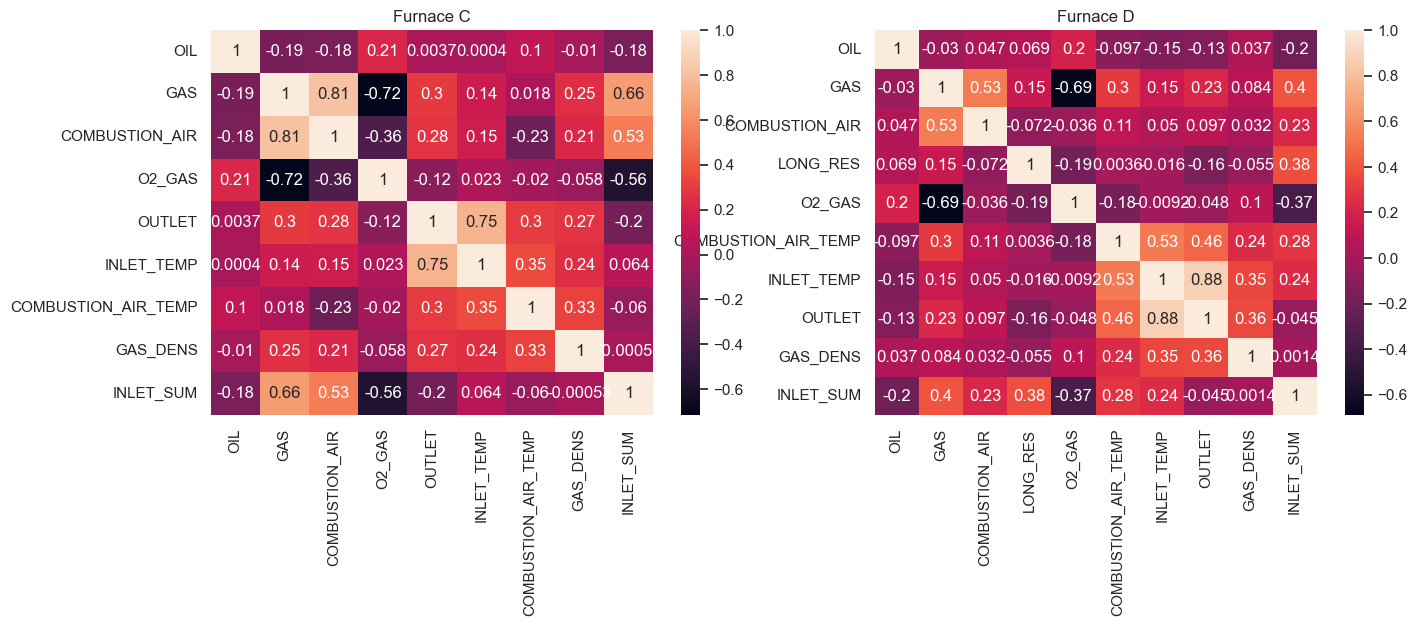

In [173]:
corr_a = clean_df_a.corr()
corr_b = clean_df_b.corr()
corr_c = clean_df_c.corr()
corr_d = clean_df_d.corr()

fig, ax =plt.subplots(1,2);
sns.set(rc={'figure.figsize':(15.7,5)})
sns.heatmap(corr_a, annot = True, ax=ax[0]);
ax[0].set_title('Furnace A');
sns.heatmap(corr_b, annot = True, ax=ax[1]);
ax[1].set_title('Furnace B');
fig.show();

fig, ax =plt.subplots(1,2);
sns.set(rc={'figure.figsize':(15.7,5)})
sns.heatmap(corr_c, annot = True, ax=ax[0]);
ax[0].set_title('Furnace C');
sns.heatmap(corr_d, annot = True, ax=ax[1]);
ax[1].set_title('Furnace D');
fig.show();

Any instance where outlet was below 280 was omitted from the analysis as it was deemed that these points either come from a down time in the system, or results from that observations may be unreliable.

In [177]:
df_a = clean_df_a[clean_df_a['OUTLET'] >= 280]
df_a.loc[df_a['OIL'] < 0, 'OIL'] = 0 

df_b = clean_df_b[clean_df_b['OUTLET'] >= 280]
df_b.loc[df_b['OIL'] < 0, 'OIL'] = 0 

df_c = clean_df_c[clean_df_c['OUTLET'] >= 280]
df_c.loc[df_c['OIL'] < 0, 'OIL'] = 0 

df_d = clean_df_d[clean_df_d['OUTLET'] >= 280]
df_d.loc[df_d['OIL'] < 0, 'OIL'] = 0

print("Furnace A:", df_a.shape[0], "observations, with", df_a.shape[1], "variables")
print("Furnace B:", df_b.shape[0], "observations, with", df_b.shape[1], "variables")
print("Furnace C:", df_c.shape[0], "observations, with", df_c.shape[1], "variables")
print("Furnace D:", df_d.shape[0], "observations, with", df_d.shape[1], "variables")

Furnace A: 30441 observations, with 9 variables
Furnace B: 29918 observations, with 9 variables
Furnace C: 30321 observations, with 9 variables
Furnace D: 29828 observations, with 10 variables


C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\272930404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.loc[df_a['OIL'] < 0, 'OIL'] = 0
C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\272930404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.loc[df_b['OIL'] < 0, 'OIL'] = 0
C:\Users\joliver0616\AppData\Local\Temp\ipykernel_6816\272930404.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.loc[df_c[

In [179]:
df_a.to_csv('../Data/clean_furnace_pre_a.csv')
df_b.to_csv('../Data/clean_furnace_pre_b.csv')
df_c.to_csv('../Data/clean_furnace_pre_c.csv')
df_d.to_csv('../Data/clean_furnace_pre_d.csv')